In [338]:
from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import pandas as pd
from PIL import Image, ImageDraw
from tqdm import tqdm


@dataclass
class Parameters:
    size: int
    center_crop_size: Optional[int] = None

In [360]:
flag = "retina"
pattern = "*"
if flag == "retina":
    pattern = "**/regular_fundus_images/**/*"
elif flag == "tissue":
    pattern = "**/All_3D/**/*"
split = "test"
size = 224
params = Parameters(size)
if flag == 'blood':
    params.center_crop_size = 200
src = Path("/mnt/jbrockma/bachelor-thesis")
data_src = src / f"data/{flag}"
split_info_df = pd.read_csv(src / f"medmnist_data_split/{flag}mnist_split_info.csv", index_col='image_id')
split_info_df.head()

split  index
image_id              
170_r2    train      0
9_r1      train      1
327_r2    train      2
70_l1     train      3
63_r1     train      4

In [361]:
idx_of_im = {im_id: idx for im_id, _, idx in split_info_df[split_info_df["split"] == split].itertuples()}
idx_of_im

{'301_l1': 0,
 '431_r1': 1,
 '382_l2': 2,
 '402_l2': 3,
 '395_r2': 4,
 '378_l2': 5,
 '328_l1': 6,
 '400_r2': 7,
 '401_l1': 8,
 '296_r1': 9,
 '318_l2': 10,
 '336_l2': 11,
 '416_l1': 12,
 '304_l1': 13,
 '348_l1': 14,
 '399_r1': 15,
 '369_r1': 16,
 '350_l1': 17,
 '267_l1': 18,
 '374_r2': 19,
 '316_r2': 20,
 '392_l2': 21,
 '322_l1': 22,
 '351_r1': 23,
 '325_l1': 24,
 '376_l1': 25,
 '399_l1': 26,
 '300_r1': 27,
 '380_r1': 28,
 '345_l2': 29,
 '414_l2': 30,
 '431_l1': 31,
 '357_l1': 32,
 '348_r2': 33,
 '401_l2': 34,
 '373_l1': 35,
 '376_l2': 36,
 '352_l1': 37,
 '349_l2': 38,
 '364_l2': 39,
 '348_r1': 40,
 '340_r2': 41,
 '390_r2': 42,
 '422_r1': 43,
 '321_r1': 44,
 '311_r1': 45,
 '416_r1': 46,
 '433_r2': 47,
 '335_r1': 48,
 '414_r2': 49,
 '358_r1': 50,
 '314_r1': 51,
 '310_r2': 52,
 '375_r2': 53,
 '333_r2': 54,
 '335_r2': 55,
 '294_l1': 56,
 '378_r1': 57,
 '364_l1': 58,
 '333_r1': 59,
 '363_l2': 60,
 '410_r2': 61,
 '345_r2': 62,
 '355_l2': 63,
 '277_l2': 64,
 '405_l1': 65,
 '392_r2': 66,
 '402

In [362]:
fp_of_idx = {}
with tqdm(desc="Building cache", total=len(split_info_df[split_info_df['split'] == split])) as pbar:
    for child in data_src.rglob(pattern):
        if child.is_file():
            try:
                idx = idx_of_im.pop(child.stem)
            except KeyError:
                continue

            fp_of_idx[idx] = child
            pbar.update()

Building cache: 100%|███████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 93.35it/s]


In [363]:
def get_src_im(idx):
    fp = fp_of_idx[idx]
    return Image.open(fp)

def would_center_crop(im):
    width, height = im.size
    return width != height

def would_use_short_edge():
    return not params.center_crop_size

def get_short_edge(im):
    return min(im.size)

def get_crop_box(im):
    width, height = im.size
    print("size", im.size)
    # whether to center-crop
    if width != height:
        print("center-cropping")
        if not params.center_crop_size:
            print('using short edge')
            # length of the short edge
            params.center_crop_size = min(width, height)

        print("using center-crop size", params.center_crop_size)

        left = (width - params.center_crop_size) // 2
        upper = (height - params.center_crop_size) // 2
        right = left + params.center_crop_size
        lower = upper + params.center_crop_size

        return left, upper, right, lower
    else:
        return [(0, 0), (width, 0), (width, height), (0, height)]

def draw_box(im, box):
    draw = ImageDraw.Draw(im)

    left, upper, right, lower = box

    draw.rectangle([left, upper, right, lower], outline='red')

    corners = [(left, upper), (right, upper), (right, lower), (left, lower)]

    # Draw green dots (circles) on the corners
    dot_radius = 5
    for corner in corners:
        draw.ellipse((corner[0] - dot_radius, corner[1] - dot_radius, corner[0] + dot_radius, corner[1] + dot_radius), fill="green")

    return im

def crop(im, box):
    return im.crop(box)

def resize(im):
    return im.resize((size, size), Image.BICUBIC)

def process(idx):
    fp = fp_of_idx[idx]
    with Image.open(fp) as im:
        width, height = im.size
        # whether to center-crop
        if width != height:
            if not params.center_crop_size:
                # length of the short edge
                center_crop_size = min(width, height)
            else:
                center_crop_size = params.center_crop_size

            left = (width - center_crop_size) // 2
            upper = (height - center_crop_size) // 2
            right = left + center_crop_size
            lower = upper + center_crop_size

            im = im.crop((left, upper, right, lower))

        return im.resize((params.size, params.size), Image.BICUBIC)

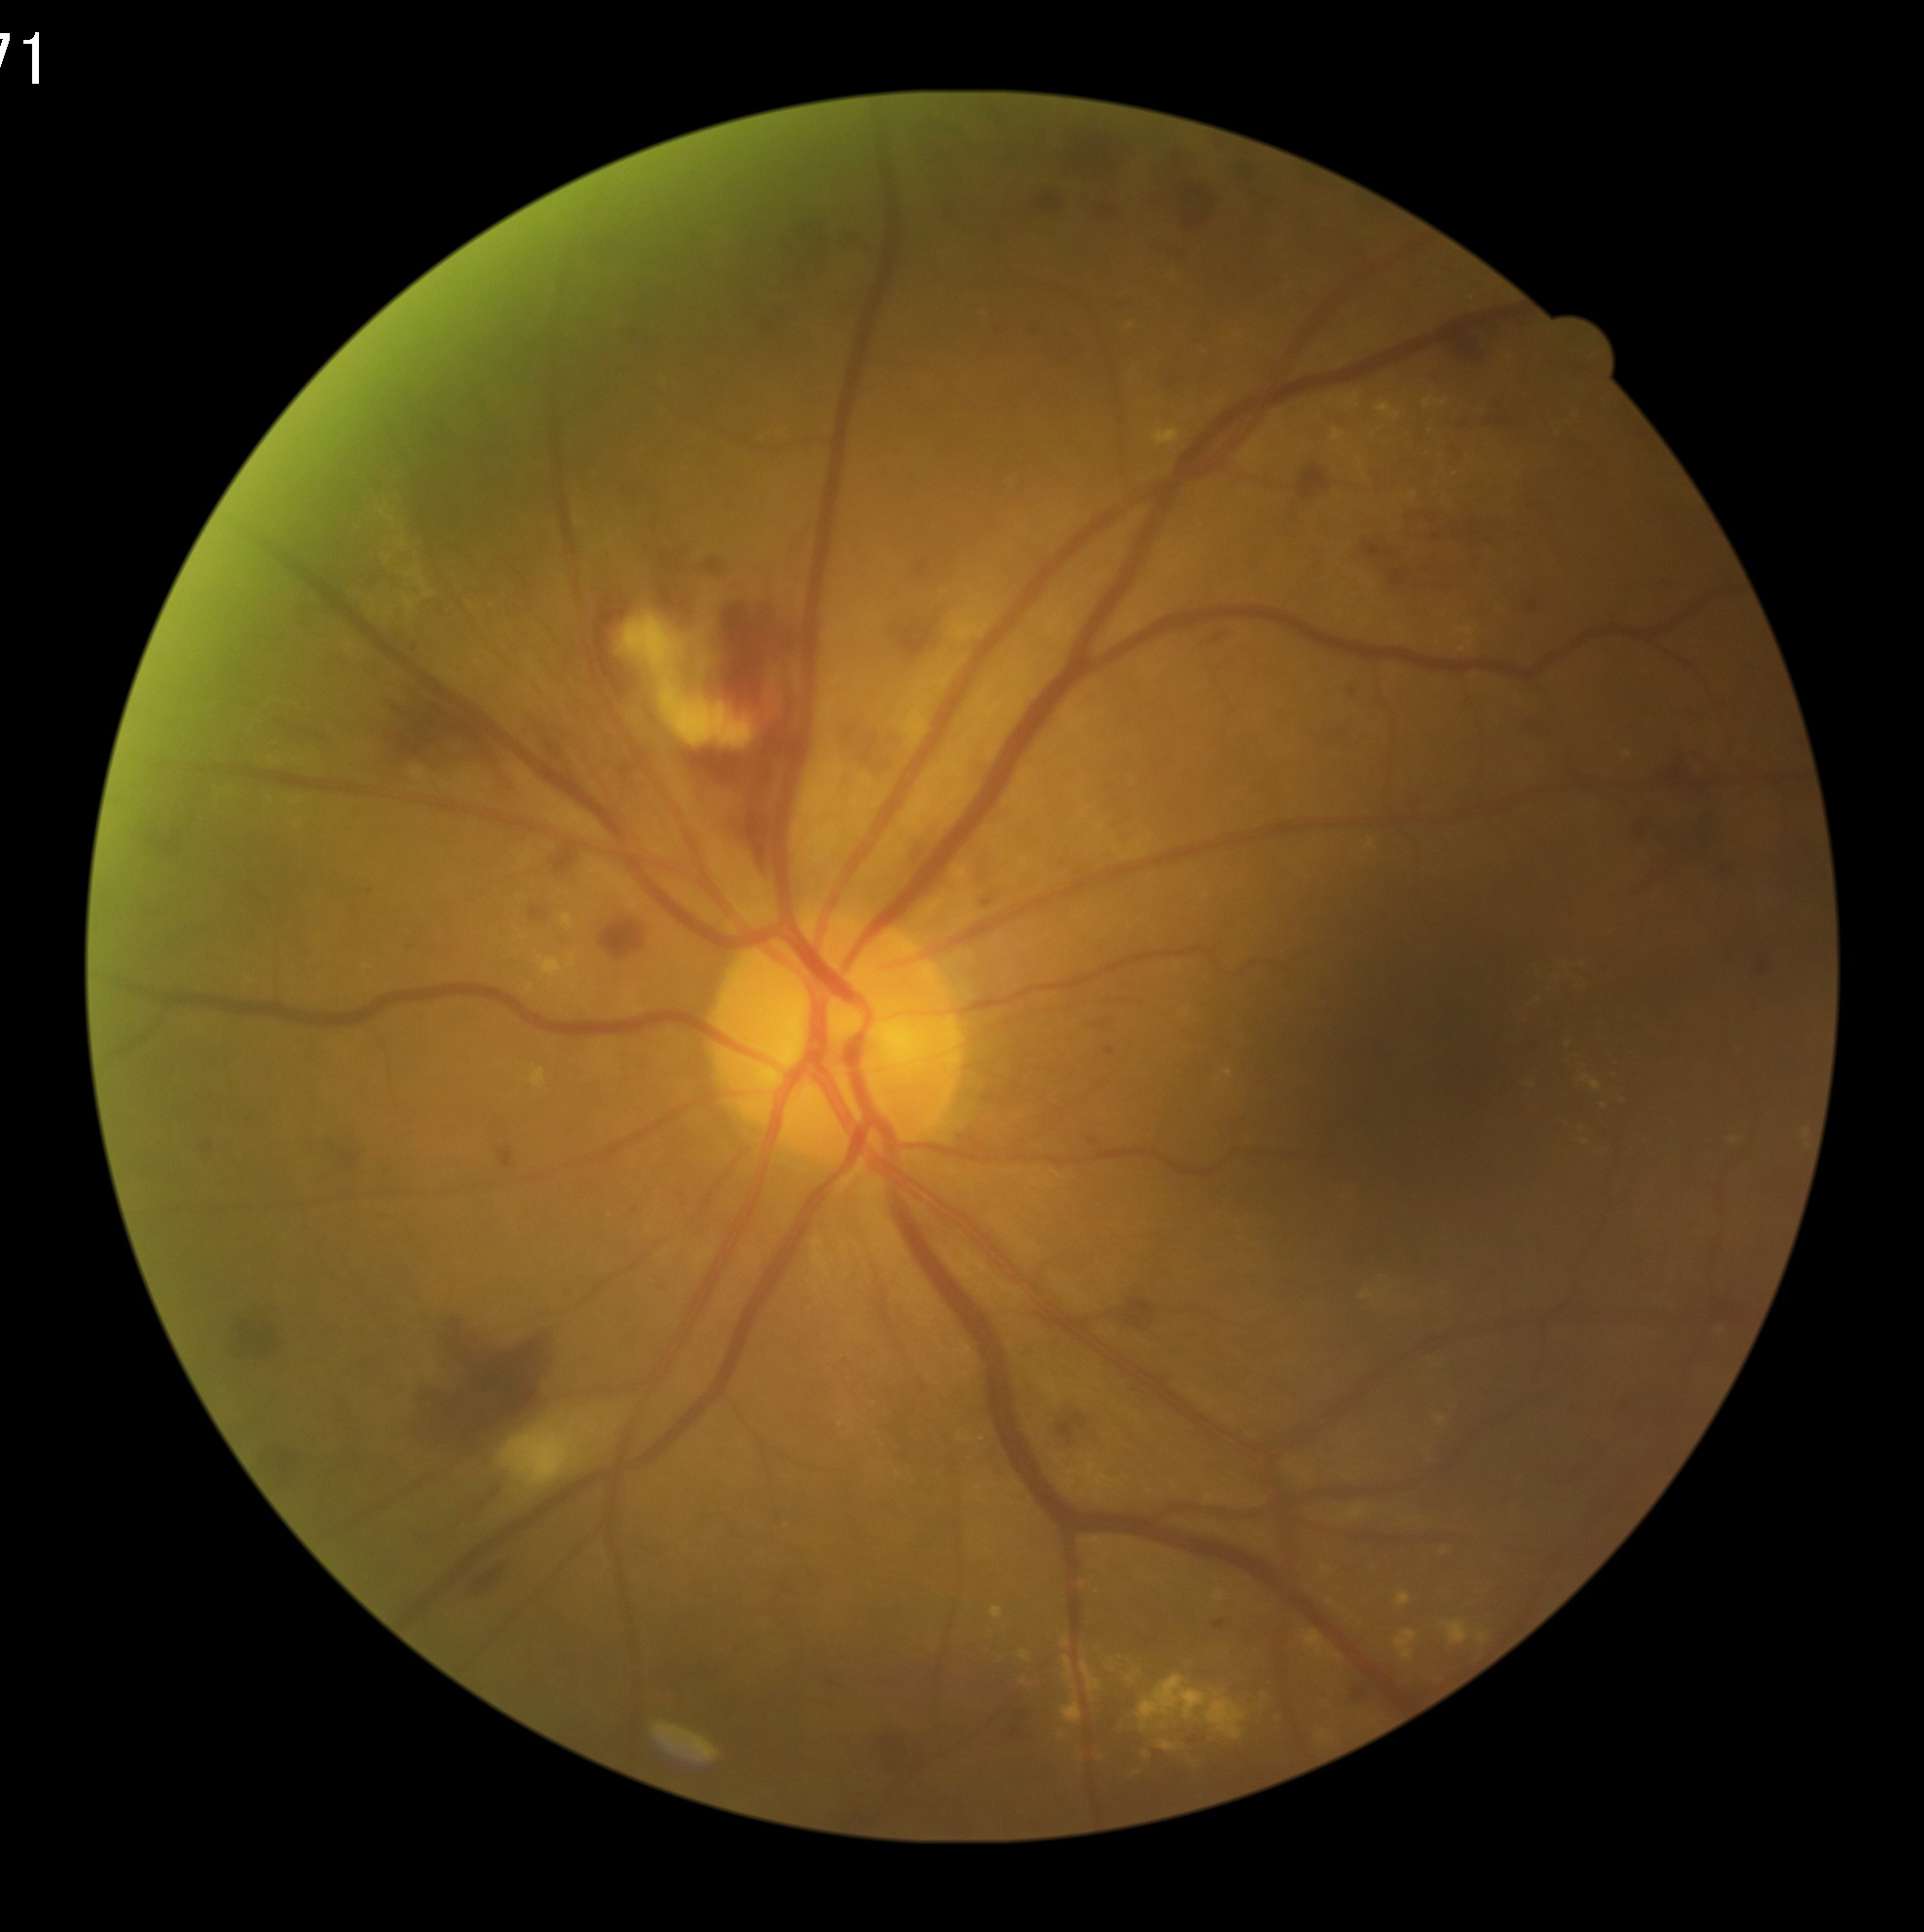

In [364]:
i = 375
img = get_src_im(i)
img

In [365]:
would_center_crop(img)

True

In [366]:
would_use_short_edge()

True

In [367]:
get_short_edge(img)

1976

In [368]:
crop_box = get_crop_box(img)
crop_box

size (1976, 1984)
center-cropping
using short edge
using center-crop size 1976


(0, 4, 1976, 1980)

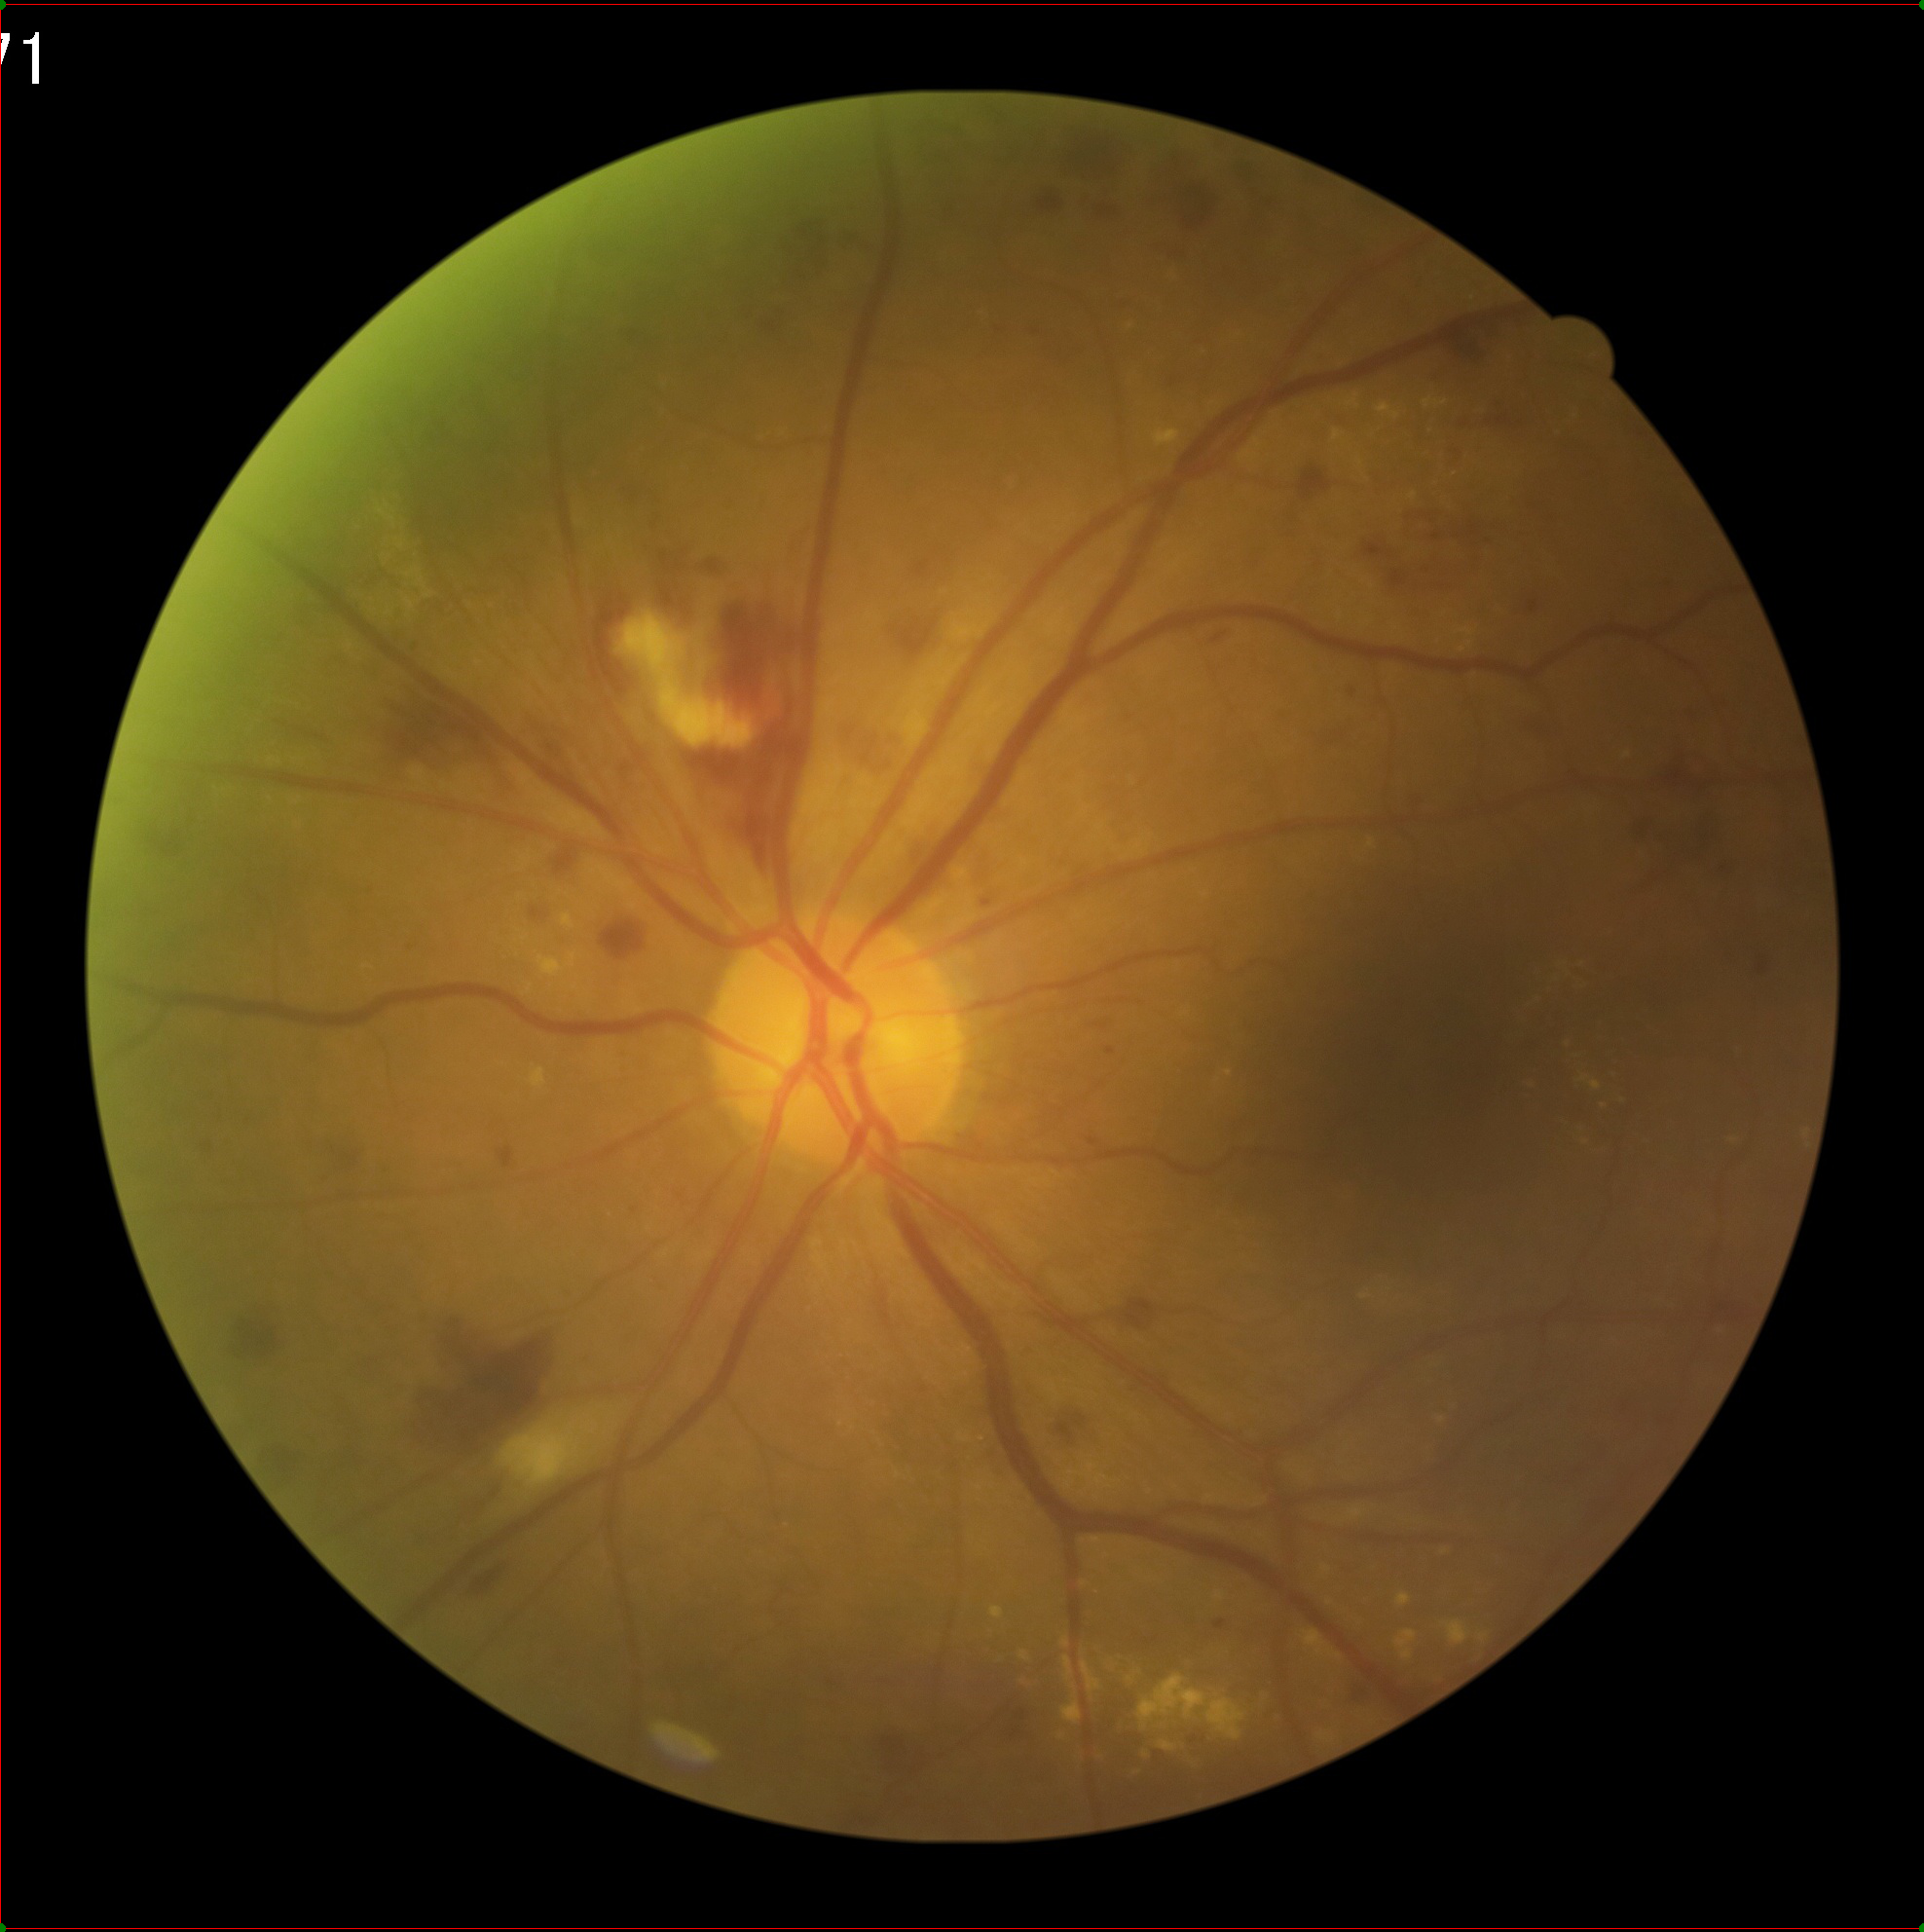

In [369]:
draw_box(img, crop_box)

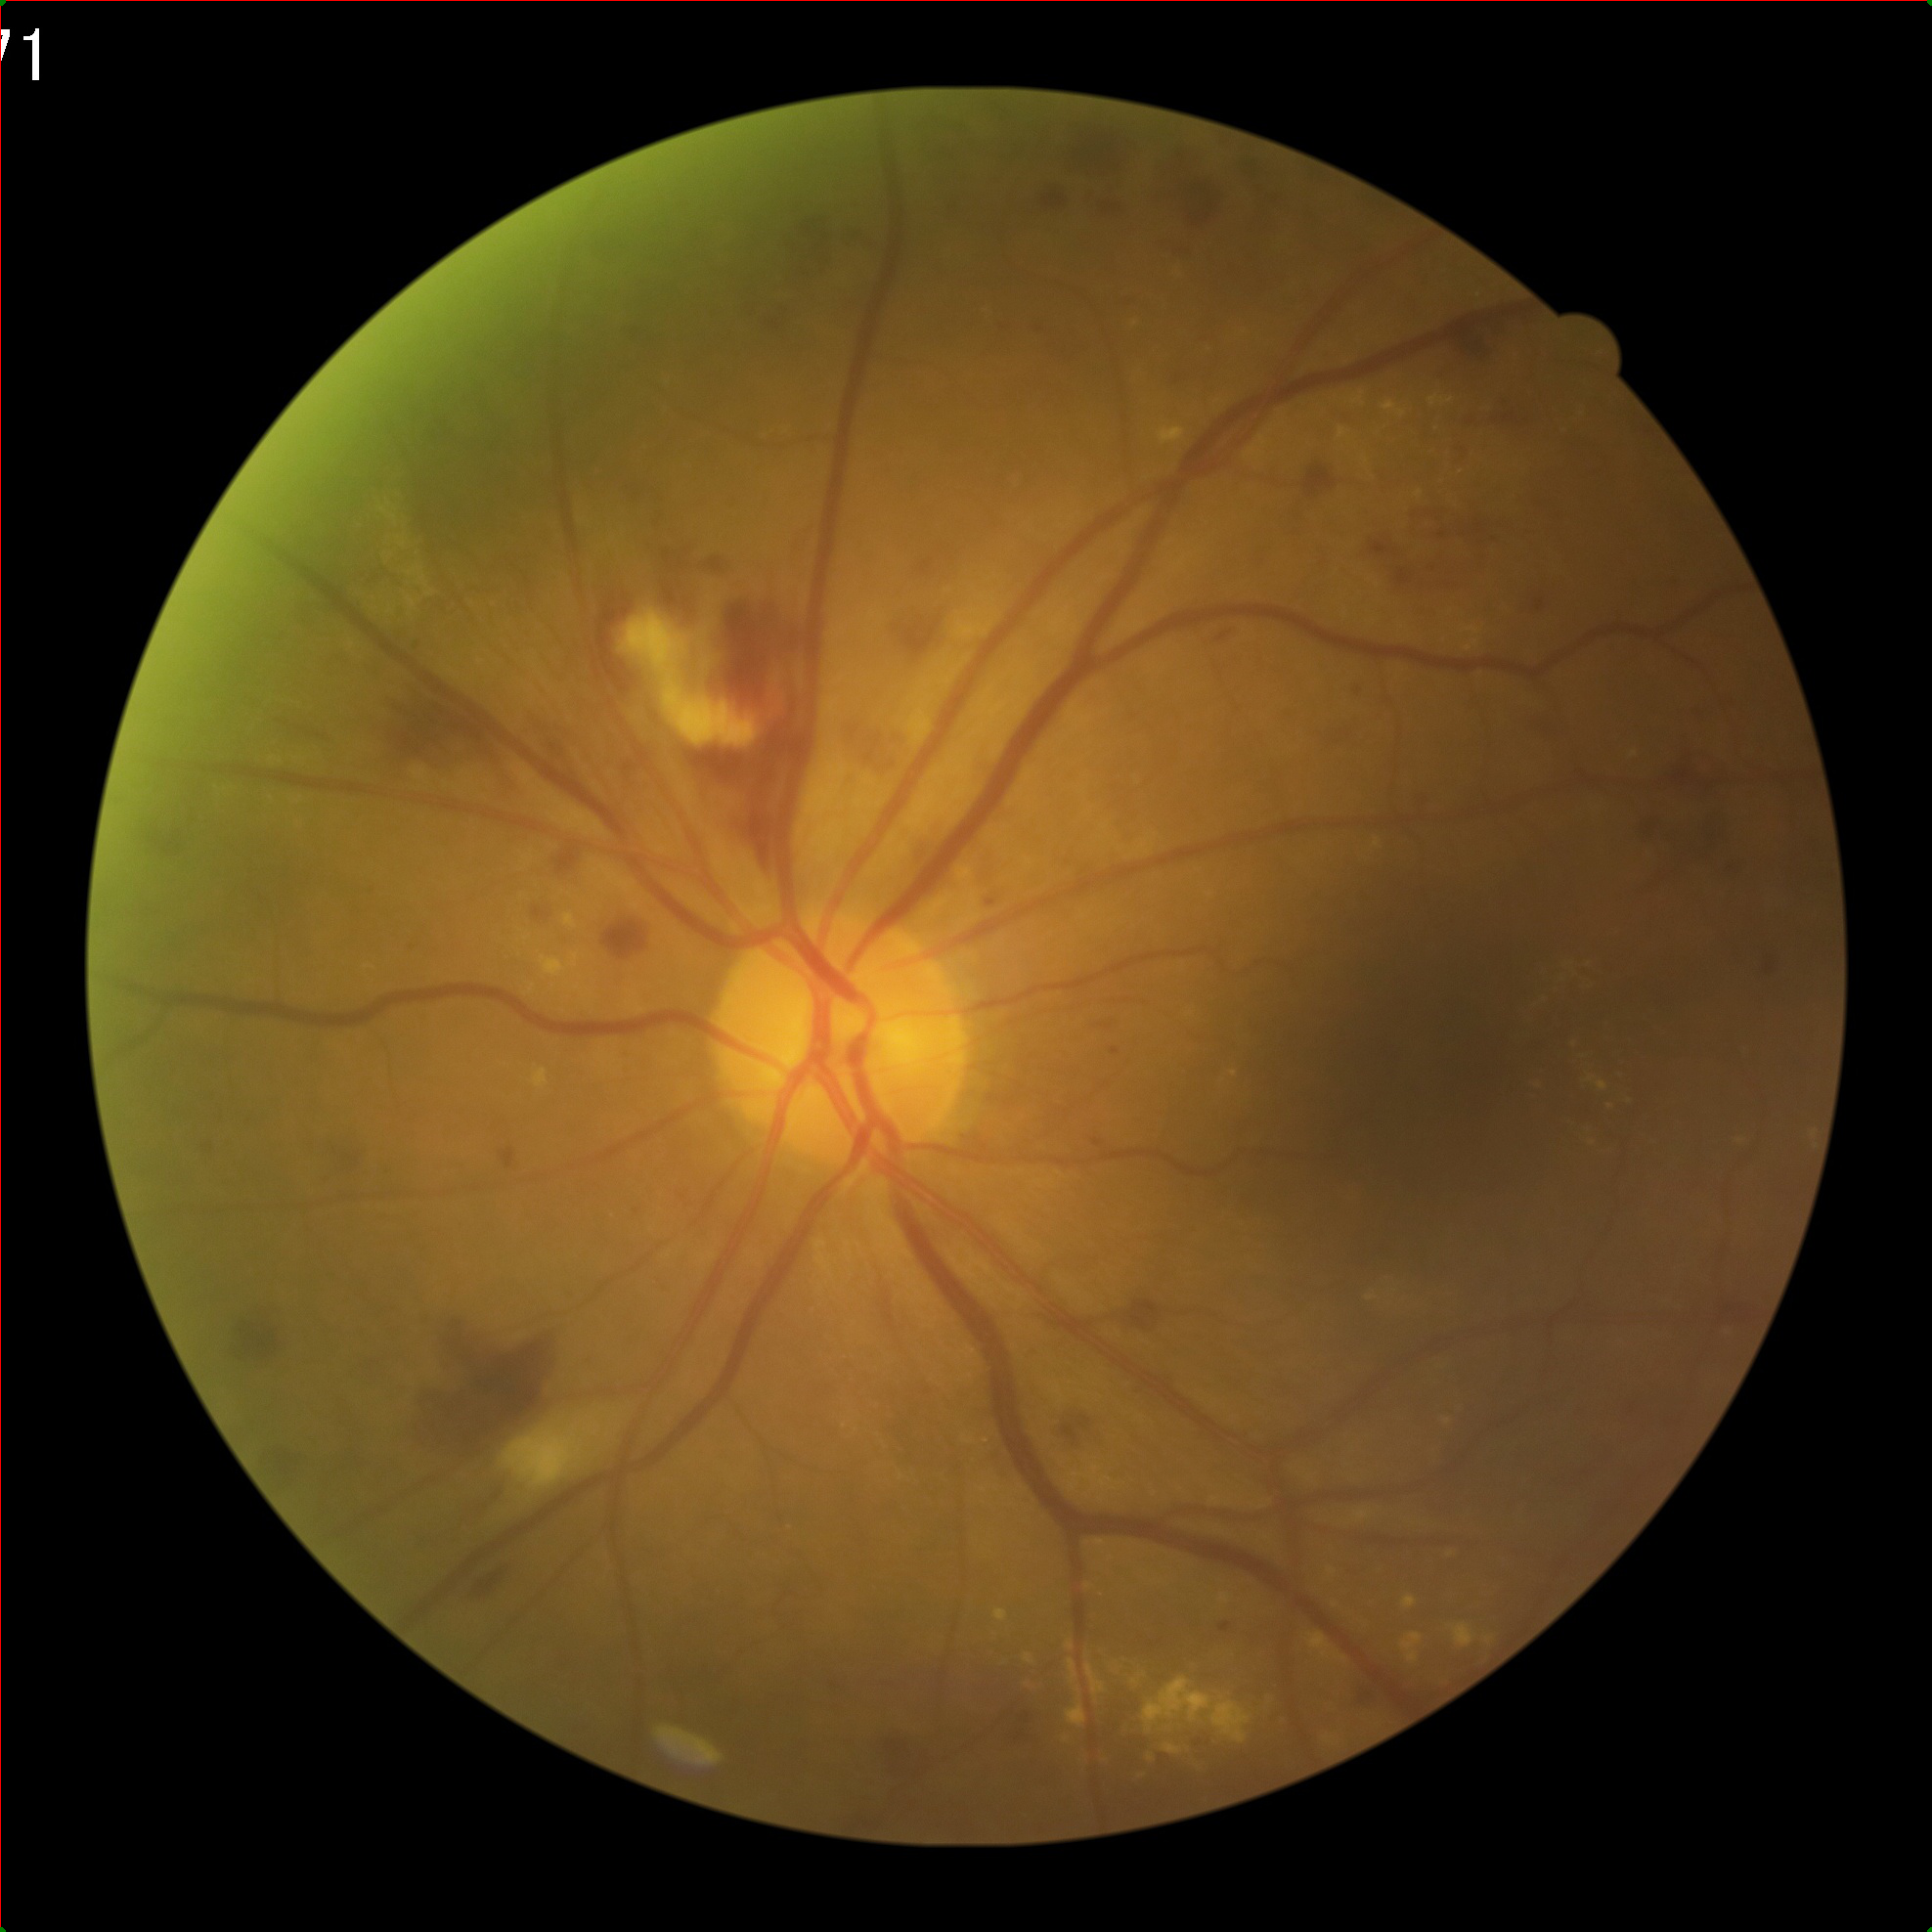

In [370]:
crop(img, crop_box)

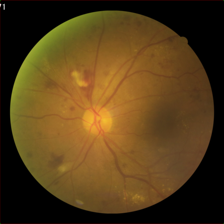

In [371]:
resize(img)

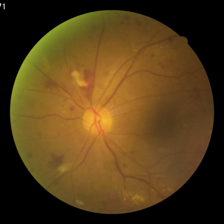

In [372]:
process(i)

In [373]:
process(i).resize((28, 28))